In [4]:
#AMZN 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load the data
# Make sure the CSV file is in the same directory as the script, or provide the full path
data = pd.read_csv('AMZN.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)

# Normalize the Close prices
scaler = MinMaxScaler(feature_range=(-1, 1))
price_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1)).flatten()

# Data Preprocessing Function
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences
sequence_length = 128
X, y = create_sequences(price_data, sequence_length)

# Split the data
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader instances
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the PositionalEncoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Define the TransformerModel class
class TransformerModel(nn.Module):
    def __init__(self, n_features, d_model, n_heads, n_hidden, n_layers, dropout):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, n_hidden, dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, n_layers)
        self.decoder = nn.Linear(d_model, n_features)
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = x.unsqueeze(-1).transpose(0, 1)  # Add a feature dimension and transpose
        x = self.pos_encoder(x)
        output = self.transformer_encoder(x)
        output = self.decoder(output)
        return output[-1]

# Instantiate the model
model = TransformerModel(n_features=1, d_model=128, n_heads=8, n_hidden=512, n_layers=4, dropout=0.1)

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss Function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Scheduler - OneCycleLR
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
# Training function
def train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, epochs, patience):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            sequences, labels = batch
            sequences, labels = sequences.to(device), labels.to(device)
            predictions = model(sequences)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        
        validation_loss = evaluate(model, test_loader, criterion)
        print(f'Epoch {epoch+1}: Training Loss: {total_loss/len(train_loader)}, Validation Loss: {validation_loss}')
        
        early_stopping(validation_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    # Load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            sequences, labels = batch
            sequences, labels = sequences.to(device), labels.to(device)
            predictions = model(sequences)
            loss = criterion(predictions, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Run the training loop
train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, epochs=50, patience=5)

# Load best model
best_model = TransformerModel(n_features=1, d_model=128, n_heads=8, n_hidden=512, n_layers=4, dropout=0.1)
best_model.load_state_dict(torch.load('checkpoint.pt'))
best_model.to(device)

# Evaluate on test data
test_loss = evaluate(best_model, test_loader, criterion)
print(f'Test Loss: {test_loss}')

# Calculate and print additional metrics
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        sequences, labels = batch
        sequences, labels = sequences.to(device), labels.to(device)
        predictions = best_model(sequences)
        y_pred.extend(predictions.view(-1).tolist())
        y_true.extend(labels.view(-1).tolist())

# Convert predictions and true values to arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

Epoch 1: Training Loss: 0.12403914498241797, Validation Loss: 0.054011245568593345
Validation loss decreased (inf --> 0.054011).  Saving model ...
Epoch 2: Training Loss: 0.011790800897072847, Validation Loss: 0.06313229124579164
EarlyStopping counter: 1 out of 5
Epoch 3: Training Loss: 0.007408013324929427, Validation Loss: 0.027164770600696404
Validation loss decreased (0.054011 --> 0.027165).  Saving model ...
Epoch 4: Training Loss: 0.004808604385550708, Validation Loss: 0.02742487413989794
EarlyStopping counter: 1 out of 5
Epoch 5: Training Loss: 0.003971290586465229, Validation Loss: 0.014549488408697976
Validation loss decreased (0.027165 --> 0.014549).  Saving model ...
Epoch 6: Training Loss: 0.002964239610575956, Validation Loss: 0.00967425701674074
Validation loss decreased (0.014549 --> 0.009674).  Saving model ...
Epoch 7: Training Loss: 0.005260304793434804, Validation Loss: 0.007849297473310597
Validation loss decreased (0.009674 --> 0.007849).  Saving model ...
Epoch 8:

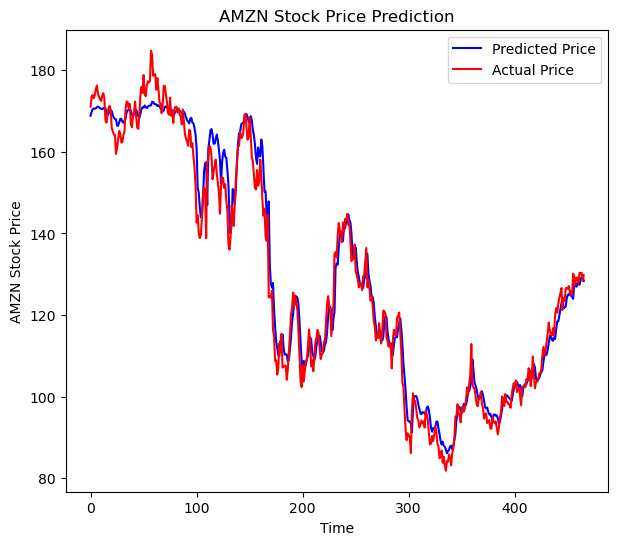

In [8]:
import matplotlib.pyplot as plt

# Since we used MinMaxScaler, we need to inverse the transformation to get the actual prices
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_rescaled = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

# Plotting the actual vs predicted prices while excluding the first 20 steps
plt.figure(figsize=(7,6))
plt.plot(y_pred_rescaled[50:], color='blue', label='Predicted Price')  # Excluding first 20 data points
plt.plot(y_true_rescaled[50:], color='red', label='Actual Price')     # Excluding first 20 data points
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMZN Stock Price')
plt.legend()

# Save the figure with 600 DPI resolution
plt.savefig('AMZN.png', dpi=600)

# Display the figure
plt.show()
